In [8]:
# usual packages
import numpy as np
import pandas as pd
pd.set_option('use_inf_as_na', True)
import csv
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn

# set font to match UI
#plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
sns.set_style("whitegrid")

labelsize = 12

colours = ['#F65058FF','#FBDE44FF','#28334AFF']
twitter = '#00acee'
feelings = ['#E46948','#ADB4B4','#7FD2DD']

sns.set_palette(colours)

# specific to analysis
import string
import textdistance
import nltk
import preprocessor as p
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import networkx as nx
from operator import itemgetter

In [9]:
# need to figure out what columns we need for the analysis and ONLY load them in.
columns = []
tag = ['bot','human','org']
path = 'Final datasets/'

In [10]:
# load in the datasets
tags = pd.read_csv("climate_tagged.csv")
tweets = pd.read_csv("tweets_climate_emergency_2.csv")
tweets.shape

(11882, 11)

In [11]:
tags.groupby('tag')['id'].count()

tag
bot        63
human    5392
org      1386
Name: id, dtype: int64

In [12]:
# need to join the tags to the tweets
tags2 = tags.iloc[:,[3,-1]]
df = tweets.merge(tags2,how="inner",left_on="username",right_on="username")

#df.to_csv("merge.csv")

print("tweets by class:")
df.groupby('tag')['id'].count()

tweets by class:


tag
bot       105
human    8854
org      2937
Name: id, dtype: int64

In [13]:
sum(df.tag.isnull())

0

In [14]:
# load in the tweets which will have tag of human,bot,org (and maybe unknown group)
# replace nan
#df = df.where((pd.notnull(df)), None)
rows,columns = df.shape

# extract the unique users with their tag and amount of tweets
users = df.groupby(['username','tag']).count().reset_index()
users = users.iloc[:,:3]
users.columns = ['username','tag','tweets']
users = users.drop_duplicates('username').reset_index(drop=True)


In [15]:
df['id']= pd.Series(range(1,df.shape[0]+1)) #starts with 1
df

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,tag
0,19/04/2020 23:59,Jackthelad1947,NaN,0,5,4,Keeping our promises: We can't let the Great B...,NaN,@ScottMorrisonMP @AnnastaciaMP @LeeanneEnoch @...,#auspol #qldpol #StopAdani #ClimateEmergency #...,1,org
1,19/04/2020 22:51,Jackthelad1947,NaN,0,4,6,It‚Äôs time to Demand a Global #GreenNewDeal T...,NaN,@BreakfastNews @RNDrive,#GreenNewDeal #CoronaCrash #ClimateEmergency #...,2,org
2,19/04/2020 22:31,Jackthelad1947,NaN,0,5,9,Is the Solution to the Coronavirus Recession a...,NaN,NaN,#GreenNewDeal #auspol #qldpol #StopAdani #Clim...,3,org
3,19/04/2020 22:14,Jackthelad1947,NaN,0,9,7,#ClimateEmergency Demand a #GreenNewDeal to cr...,NaN,@BreakfastNews @mjrowland68 @RNDrive @RNBreakf...,#ClimateEmergency #GreenNewDeal #CoronaCrash #...,4,org
4,19/04/2020 00:36,Jackthelad1947,NaN,1,7,12,We need a vision for a Green New World after t...,NaN,NaN,#CoronaVirus #ClimateEmergency #GreenNewDeal #...,5,org
...,...,...,...,...,...,...,...,...,...,...,...,...
11891,05/04/2020 00:34,EdenHar36652477,quea_ali,1,1,11,And with that...the climate emergency dies...o...,NaN,NaN,NaN,11892,human
11892,05/04/2020 00:24,HHPumpco_BCE_II,HHPumpco_BCE_II,1,0,2,Wait till they declare a ‚ÄúClimate Emergency‚...,NaN,NaN,NaN,11893,human
11893,05/04/2020 00:19,bill555g,NaN,0,0,0,The government uses our money to fund fossil f...,NaN,NaN,#climateemergency,11894,human
11894,05/04/2020 00:09,kmarciniec,NaN,0,0,0,I just signed the petition urging @LibertyMutu...,NaN,@LibertyMutual,#KeystoneXL #TransMountain #ClimateEmergency #...,11895,human


In [16]:
# hashtag cleaning - but useful for networks later.
df_h = pd.DataFrame(df.iloc[:,[9,10]])

# lowercase, drop# and remove the first empty item.
df_h.dropna(subset = ["hashtags"], inplace=True)

if df_h.hashtags.empty == False:
    df_h['hashtags'] = df_h['hashtags'].str.casefold()
    df_h['hashtags'] = df_h['hashtags'].str.split('#')
    df_h['hashtags'] = df_h['hashtags'].apply(
    lambda row: [val for val in row if val != ''])

    strip = []
    for i in df_h['hashtags']:
        i = [x.strip(' ') for x in i]
        strip.append(i)
    df_h['hashtags_'] = strip

else:
    None
df = df.merge(df_h, how='left', left_on='id', right_on='id')
df = df.drop(columns=['hashtags_x','hashtags_y'])

In [17]:
# convert mentions to a list
df_h = pd.DataFrame(df.iloc[:,[8,9]])

# split by @ and spaces
df_h.dropna(subset = ["mentions"], inplace=True)

if df_h.mentions.empty == False:
    df_h['mentions'] = df_h['mentions'].str.split('@')
    df_h['mentions_'] = df_h['mentions'].apply(lambda row: [val for val in row if val != ''])
    
df = df.merge(df_h, how='left', left_on='id', right_on='id')
df = df.drop(columns=['mentions_x','mentions_y'])

In [18]:
# tokenise tweets
    # add any unusual characters to be removed
punctuation = string.punctuation
other = '“¡…'
punctuation2 = punctuation + other
stop_words = stopwords.words('english')
    
tokens = []
cleaned = []

df['text'] = df['text'].str.casefold()

for i in df['text']:
    # clean drops items mentions, hasthags, hyperlinks, emojis etc
    clean = p.clean(i)
    # token seperates tweets into lists of words
    token = word_tokenize(clean)
    # words removes punctuated items, empty items and stopwords
    words = [''.join(c for c in s if c not in punctuation2) for s in token]
    words = [s for s in words if len(s) > 1]
    words = [w for w in words if not w in stop_words]
    sentence = ' '.join(word for word in words)
    tokens.append(words)
    cleaned.append(sentence)

df['tokens'] = tokens
df['text_clean'] = cleaned

In [19]:
# table showing tag, percentage split of users and tweets
user_split = users.groupby('tag')['username'].count()
tweet_split = users.groupby('tag')['tweets'].sum()
tag = user_split.index.tolist()
print(tweet_split)
user_pct = [round(i/sum(user_split)*100) for i in user_split]
tweet_pct = [round(i/sum(tweet_split)*100) for i in tweet_split] 
table_1 = pd.DataFrame({'tag':tag,'users %':user_pct,'tweets %':tweet_pct})
table_1



# do we want to add a percentage sign to values instead?

tag
bot       105
human    8854
org      2937
Name: tweets, dtype: int64


,tag,users %,tweets %
0,bot,1,1
1,human,79,74
2,org,20,25


Text(0, 0.5, '')

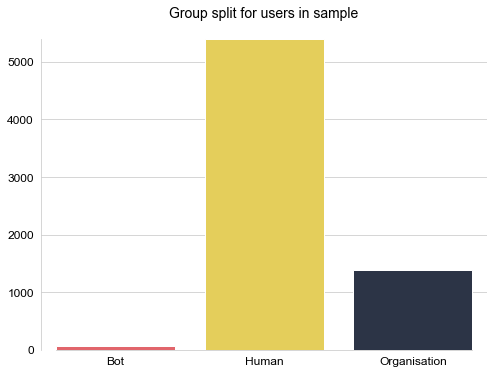

In [20]:
# plot to show the split of users
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x=user_split.index,y=user_split)
plt.title('Group split for users in sample',fontsize=14)

# sort the styling
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.set_xticklabels(['Bot','Human','Organisation'])
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.set_xlabel("")
ax.set_ylabel("")
# we could show this as say 50 people, and color code the dots for each proportion - if i can be bothered.

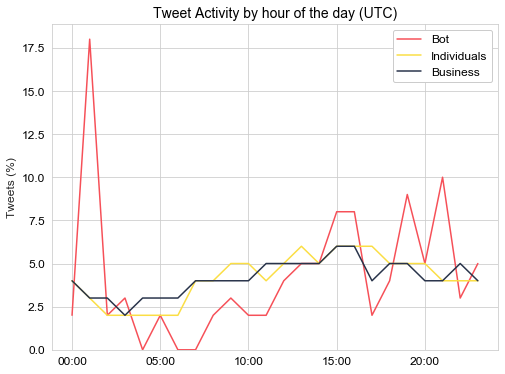

In [21]:
# hourly tweet activity - change to % over day..
fig, ax = plt.subplots(figsize=(8,6))
df['date'] = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M')
df['hour'] = df.date.apply(lambda x: x.hour)
hours = df.pivot_table(index='hour',values='id', columns='tag',aggfunc='count',margins = False,fill_value=0)
hours_pct = (100. * hours / hours.sum()).round(0)

ax = sns.lineplot(data=hours_pct,dashes=False)
# sort the styling
plt.title('Tweet Activity by hour of the day (UTC)',fontsize=14)

ax.set_xlabel('',fontsize=labelsize)
ax.set_ylabel('Tweets (%)',fontsize=labelsize)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(['Bot','Individuals','Business'],framealpha=1,fontsize=labelsize)
ax.set_xticklabels(['00:00','00:00','05:00','10:00','15:00','20:00'])
ax.set_ylim(ymin=0)

plt.show()

In [22]:
tags3 = tags.loc[:,['username','days_active','followers']]
df = df.merge(tags3,how="inner",left_on="username",right_on="username")

In [23]:
df

,date,username,to,replies,retweets,favorites,text,geo,id,tag,hashtags_,mentions_,tokens,text_clean,hour,days_active,followers
0,2020-04-19 23:59:00,Jackthelad1947,NaN,0,5,4,keeping our promises: we can't let the great b...,NaN,1,org,"[auspol, qldpol, stopadani, climateemergency, ...","[ScottMorrisonMP , AnnastaciaMP , LeeanneEnoch...","[keeping, promises, ca, nt, let, great, barrie...",keeping promises ca nt let great barrier reef ...,23,3562,35204
1,2020-04-19 22:51:00,Jackthelad1947,NaN,0,4,6,it‚äôs time to demand a global #greennewdeal t...,NaN,2,org,"[greennewdeal, coronacrash, climateemergency, ...","[BreakfastNews , RNDrive]","[it‚äôs, time, demand, global, recover, need, ...",it‚äôs time demand global recover need global ...,22,3562,35204
2,2020-04-19 22:31:00,Jackthelad1947,NaN,0,5,9,is the solution to the coronavirus recession a...,NaN,3,org,"[greennewdeal, auspol, qldpol, stopadani, clim...",NaN,"[solution, coronavirus, recession, global]",solution coronavirus recession global,22,3562,35204
3,2020-04-19 22:14:00,Jackthelad1947,NaN,0,9,7,#climateemergency demand a #greennewdeal to cr...,NaN,4,org,"[climateemergency, greennewdeal, coronacrash, ...","[BreakfastNews , mjrowland68 , RNDrive , RNBre...","[demand, create, millions, jobs, ‚å¶‚å©, ‚å¶‚å...",demand create millions jobs ‚å¶‚å© ‚å¶‚å© ‚å¶‚...,22,3562,35204
4,2020-04-19 00:36:00,Jackthelad1947,NaN,1,7,12,we need a vision for a green new world after t...,NaN,5,org,"[coronavirus, climateemergency, greennewdeal, ...",NaN,"[need, vision, green, new, world]",need vision green new world,0,3562,35204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11919,2020-04-05 00:34:00,EdenHar36652477,quea_ali,1,1,11,and with that...the climate emergency dies...o...,NaN,11892,human,NaN,NaN,"[climate, emergency, dies, better, denier, gov...",climate emergency dies better denier govt virt...,0,768,2183
11920,2020-04-05 00:24:00,HHPumpco_BCE_II,HHPumpco_BCE_II,1,0,2,wait till they declare a ‚äúclimate emergency‚...,NaN,11893,human,NaN,NaN,"[wait, till, declare, ‚äúclimate, emergency‚äù...",wait till declare ‚äúclimate emergency‚äù must...,0,88,727
11921,2020-04-05 00:19:00,bill555g,NaN,0,0,0,the government uses our money to fund fossil f...,NaN,11894,human,[climateemergency],NaN,"[government, uses, money, fund, fossil, fuel, ...",government uses money fund fossil fuel project...,0,2513,9
11922,2020-04-05 00:09:00,kmarciniec,NaN,0,0,0,i just signed the petition urging @libertymutu...,NaN,11895,human,"[keystonexl, transmountain, climateemergency, ...",[LibertyMutual],"[signed, petition, urging, stop, insuring, tar...",signed petition urging stop insuring tar sands...,0,4029,1027


In [24]:
# average replies, retweets, followers and account age
replies = df.groupby('tag')['replies'].mean()
retweets = df.groupby('tag')['retweets'].mean()
age = df.groupby('tag')['days_active'].mean()
followers = df.groupby('tag')['followers'].mean()


table_2 = pd.DataFrame({'replies':replies,
                        'retweets':retweets, 
                        'age':age,
                        'followers':followers}).reset_index()
table_2

,tag,replies,retweets,age,followers
0,bot,0.019048,0.171429,1516.409524,12.352381
1,human,0.337136,1.745765,2122.846510,1140.731421
2,org,0.889713,7.602698,2398.629680,44143.986172


In [25]:
df = df.iloc[:,:-2]

In [26]:
# most common key words for each group
table_3 = pd.DataFrame(columns=['bot','human','org'])

for i in tag:
    sliced = df[df['tag'] == i].copy()
    words_only = sliced['tokens']
    tokens = []
    for sublist in words_only:
        for item in sublist:
            tokens.append(item)


    freq = pd.DataFrame({'tokens':tokens,'count':1})
    word_frequency = freq.groupby(['tokens']).count()
    word_frequency = word_frequency.sort_values('count',ascending=False)
    word_frequency_50 = pd.DataFrame(word_frequency.head(5))
    l = list(word_frequency_50.index)
    table_3[i] = l
table_3

,bot,human,org
0,climate,climate,climate
1,emergency,emergency,emergency
2,world,people,change
3,online,world,stop
4,people,stop,us


In [27]:
# most common hashtag -  to compare with hashtags
table_4 = pd.DataFrame(columns=['bot','human','org'])

for i in tag:
    sliced = df[df['tag'] == i].copy()
    sliced.dropna(subset = ["hashtags_"], inplace=True)
    words_only = sliced['hashtags_']
    tokens = []
    for sublist in words_only:
        for item in sublist:
            tokens.append(item)


    freq = pd.DataFrame({'tokens':tokens,'count':1})
    word_frequency = freq.groupby(['tokens']).count()
    word_frequency = word_frequency.sort_values('count',ascending=False)
    word_frequency_50 = pd.DataFrame(word_frequency.head(5))
    l = list(word_frequency_50.index)
    print(l)

['strikewithus', 'earthdaylive', 'digitalclimatestrike', 'climateemergency', 'australiaburning']
['climateemergency', 'climatechange', 'climatecrisis', 'earthdaylive', 'strikewithus']
['climateemergency', 'climatecrisis', 'climatechange', 'covid19', 'coronavirus']


In [28]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841 entries, 0 to 6840
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      6841 non-null   int64  
 1   id                              6841 non-null   int64  
 2   name                            6841 non-null   object 
 3   username                        6841 non-null   object 
 4   location                        5132 non-null   object 
 5   url                             3057 non-null   object 
 6   description                     6046 non-null   object 
 7   followers                       6841 non-null   int64  
 8   friends                         6841 non-null   int64  
 9   favourites_count                6841 non-null   int64  
 10  statuses_count                  6841 non-null   int64  
 11  default_profile                 6841 non-null   int64  
 12  default_profile_image           68

In [29]:
# most popular users
for i in tag:
    print(i+"s")
    group = tags[tags['tag'] == i]
    group = group.set_index('username')
    #group = group.nlargest(5,'followers_friends_ratio')
    group = group.iloc[:,[81,27,48]]
    group = np.mean(group,axis=0)
    print(group,"\n")

bots
followers_friends_ratio               0.260861
average_minutes_between_tweets    47330.333333
w/urlR_OT                            77.113712
dtype: float64 

humans
followers_friends_ratio              1.905070
average_minutes_between_tweets    4182.493779
w/urlR_OT                           54.372661
dtype: float64 

orgs
followers_friends_ratio            100.003247
average_minutes_between_tweets    1272.868687
w/urlR_OT                           68.829496
dtype: float64 



In [30]:
# basic sentiment analysis (pos,neg,neutral)
res = []
for i in df['text']:
    j = p.clean(i)
    testimonial = TextBlob(j)
    res.append(testimonial.sentiment.polarity)
df['sent'] = res

([], <a list of 0 Text yticklabel objects>)

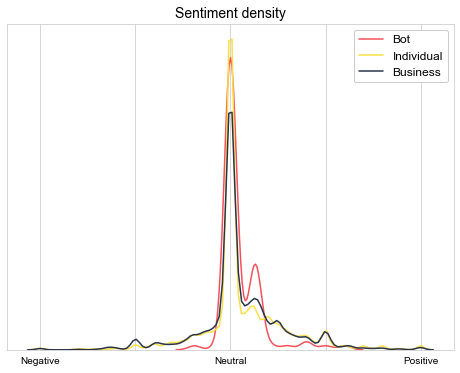

In [31]:
# plotting density
fig, ax = plt.subplots(figsize=(8,6))
for i in tag:
    sliced = df[df['tag']==i]
    ax = sns.kdeplot(sliced.sent)
    
plt.legend(['Bot','Individual','Business'],framealpha=1,fontsize=labelsize)
plt.title('Sentiment density',fontsize=14)
ax.set_xticklabels(['','Negative','','Neutral','','Positive'])
plt.yticks([])

In [32]:
df

,date,username,to,replies,retweets,favorites,text,geo,id,tag,hashtags_,mentions_,tokens,text_clean,hour,sent
0,2020-04-19 23:59:00,Jackthelad1947,NaN,0,5,4,keeping our promises: we can't let the great b...,NaN,1,org,"[auspol, qldpol, stopadani, climateemergency, ...","[ScottMorrisonMP , AnnastaciaMP , LeeanneEnoch...","[keeping, promises, ca, nt, let, great, barrie...",keeping promises ca nt let great barrier reef ...,23,0.800000
1,2020-04-19 22:51:00,Jackthelad1947,NaN,0,4,6,it‚äôs time to demand a global #greennewdeal t...,NaN,2,org,"[greennewdeal, coronacrash, climateemergency, ...","[BreakfastNews , RNDrive]","[it‚äôs, time, demand, global, recover, need, ...",it‚äôs time demand global recover need global ...,22,0.041667
2,2020-04-19 22:31:00,Jackthelad1947,NaN,0,5,9,is the solution to the coronavirus recession a...,NaN,3,org,"[greennewdeal, auspol, qldpol, stopadani, clim...",NaN,"[solution, coronavirus, recession, global]",solution coronavirus recession global,22,0.000000
3,2020-04-19 22:14:00,Jackthelad1947,NaN,0,9,7,#climateemergency demand a #greennewdeal to cr...,NaN,4,org,"[climateemergency, greennewdeal, coronacrash, ...","[BreakfastNews , mjrowland68 , RNDrive , RNBre...","[demand, create, millions, jobs, ‚å¶‚å©, ‚å¶‚å...",demand create millions jobs ‚å¶‚å© ‚å¶‚å© ‚å¶‚...,22,0.000000
4,2020-04-19 00:36:00,Jackthelad1947,NaN,1,7,12,we need a vision for a green new world after t...,NaN,5,org,"[coronavirus, climateemergency, greennewdeal, ...",NaN,"[need, vision, green, new, world]",need vision green new world,0,-0.031818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11919,2020-04-05 00:34:00,EdenHar36652477,quea_ali,1,1,11,and with that...the climate emergency dies...o...,NaN,11892,human,NaN,NaN,"[climate, emergency, dies, better, denier, gov...",climate emergency dies better denier govt virt...,0,0.166667
11920,2020-04-05 00:24:00,HHPumpco_BCE_II,HHPumpco_BCE_II,1,0,2,wait till they declare a ‚äúclimate emergency‚...,NaN,11893,human,NaN,NaN,"[wait, till, declare, ‚äúclimate, emergency‚äù...",wait till declare ‚äúclimate emergency‚äù must...,0,-0.166667
11921,2020-04-05 00:19:00,bill555g,NaN,0,0,0,the government uses our money to fund fossil f...,NaN,11894,human,[climateemergency],NaN,"[government, uses, money, fund, fossil, fuel, ...",government uses money fund fossil fuel project...,0,-0.400000
11922,2020-04-05 00:09:00,kmarciniec,NaN,0,0,0,i just signed the petition urging @libertymutu...,NaN,11895,human,"[keystonexl, transmountain, climateemergency, ...",[LibertyMutual],"[signed, petition, urging, stop, insuring, tar...",signed petition urging stop insuring tar sands...,0,0.000000


### Analysis of seperate classes - focusing on individuals mostly

In [33]:
df_tag = df[df['tag']=='human'].copy()
df_tag.shape

(8854, 16)

sentiment
negative    1487
neutral     3864
positive    3484
Name: id, dtype: int64


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

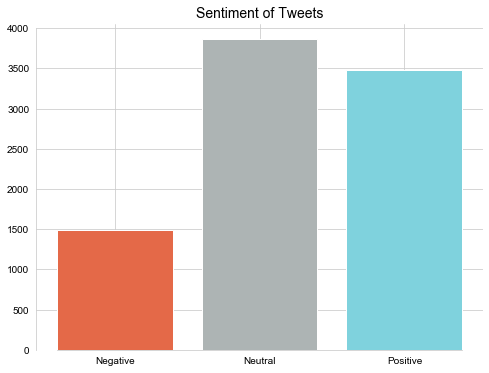

In [34]:
# recode for positive neutral and negative
df_tag['sentiment'] = pd.cut(df_tag['sent'], bins=[-1, -0.0001,0.0001, 1], labels=['negative', 'neutral', 'positive'])

# group by sentiment
sentiment = df_tag.groupby('sentiment')['id'].count()
print(sentiment)

# plot to show the split of users
sentiment = df_tag.groupby('sentiment')['id'].count()
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(x=sentiment.index,height=sentiment,color=feelings)
plt.title('Sentiment of Tweets',fontsize=14)

# sort the styling
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.set_xticklabels(['Negative','Neutral','Positive'])

In [35]:
hashtags = df_tag.iloc[:,[1,10]]

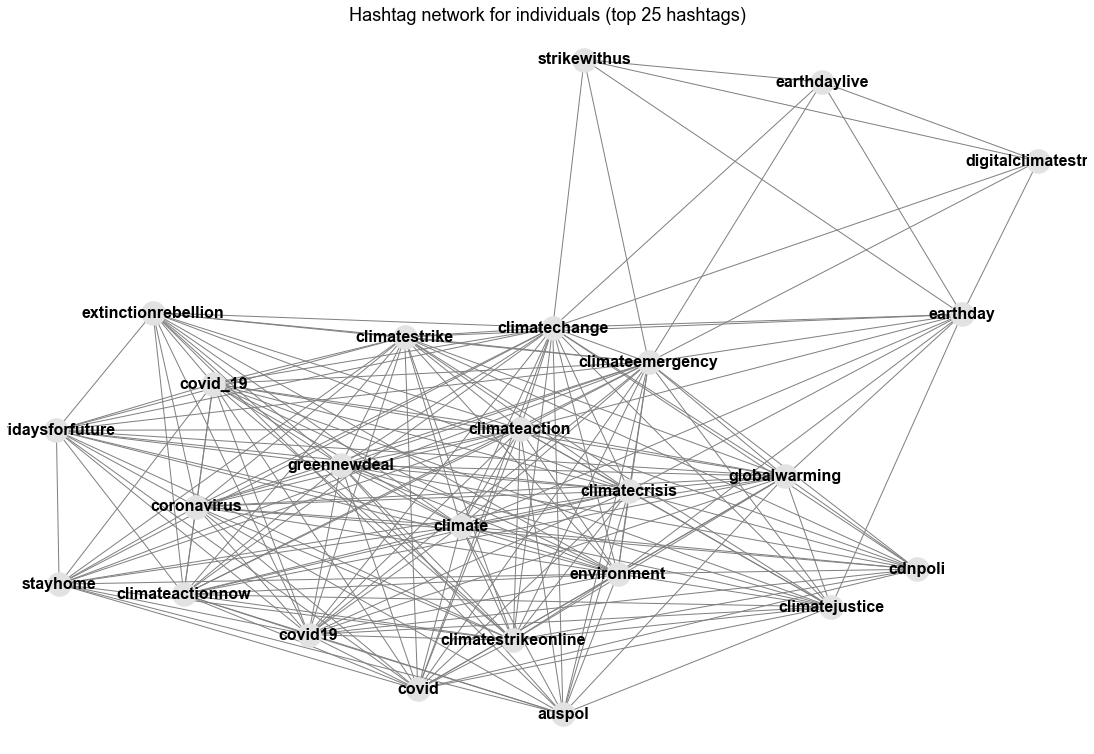

In [36]:
# top25 hashtag network
#df2 = df[df['tag'] == 'human']
hashtags = pd.DataFrame(df_tag.iloc[:,[1,10]])
hashtags.dropna(subset = ["hashtags_"], inplace=True)
user_to_hashtags=dict(hashtags.values) 

d = user_to_hashtags 
inverse = dict() 
for key in d: 
    # Go through the list that is saved in the dict:
    for item in d[key]:
        # Check if in the inverted dict the key exists
        if item not in inverse: 
                # If not create a new list
            inverse[item] = [key] 
        else: 
            inverse[item].append(key) 
e = inverse

sorted_items = sorted(e.items(), key = lambda item : len(item[1]))
hashtag_to_users = dict(sorted_items[-25:])

test = pd.DataFrame(list(hashtag_to_users.items()),columns = ['hashtag','users']) 

user_to_hashtags=dict(test[['hashtag','users']].values) 
#a more convenient data structure: a dictionary with users as keys and the list of hashtags they use as values.

B = nx.Graph() #create an empty graph

for user in user_to_hashtags: #loop over all the users
    for hashtag in user_to_hashtags[user]: #for each user loop over the hashtags they use
        B.add_edge(user,hashtag) #add the edge User<->hashtag

actual_users_with_hashtags = [x for x in list(set(test.hashtag)) if x in B.nodes()] 
G = nx.bipartite.weighted_projected_graph(B,nodes =actual_users_with_hashtags) # creates the graph object

plt.figure(figsize=(15,10))
nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=600, \
    node_color='#E2E2E2', edge_color = 'grey',linewidths=0.01, font_size=16, \
    font_weight='bold', with_labels=True)
plt.title("Hashtag network for individuals (top 25 hashtags)",fontsize=18)
plt.savefig("hashtagnet2.png")
plt.show()

In [37]:
# mentions network

In [38]:
def tolist(value):
    return [value]

df1 = df.iloc[:,[1,2,11]].copy()
df1['new'] = df1.to.map(tolist) + df1.mentions_.map(tolist)

In [39]:
dropped = df1.new.apply(lambda l: [x for x in l if x not in ['', np.nan]])

In [40]:
df1['new'] = dropped
df1 = df1[~df1.new.str.len().eq(0)]
df1.to = df['to'].fillna('None')
df1.mentions_ = df['mentions_'].fillna('None')
df1['mentions_'] = [','.join(map(str, l)) for l in df1['mentions_']]
df1['merged'] = df1[['to', 'mentions_']].agg(','.join, axis=1)
df1['merged'] = [x.strip('()').split(',') for x in df1['merged']]

In [41]:
terms = ['None','N','o','n','e']
results = []
for i in df1.merged:
    new = [x for x in i if x not in terms]
    results.append(new)
    
df2 = df1.iloc[:,[0]].copy()
df2['mentions'] = results
df2.columns = df2.columns.str.replace(' ', '')
df2

,username,mentions
0,Jackthelad1947,"[ScottMorrisonMP , AnnastaciaMP , LeeanneEnoch..."
1,Jackthelad1947,"[BreakfastNews , RNDrive]"
3,Jackthelad1947,"[BreakfastNews , mjrowland68 , RNDrive , RNBre..."
8,Jackthelad1947,"[BreakfastNews , mjrowland68]"
9,Jackthelad1947,"[ScottMorrisonMP , AnnastaciaMP , LeeanneEnoch..."
...,...,...
11918,RicochetRowdy,"[Lebeaucarnew, GerberKawasaki]"
11919,EdenHar36652477,[quea_ali]
11920,HHPumpco_BCE_II,[HHPumpco_BCE_II]
11922,kmarciniec,[LibertyMutual]


In [43]:
user_to_hashtags=dict(df2.values) 
user_to_hashtags = {k.replace(' ', ''): v for k, v in user_to_hashtags.items()}

In [44]:
d = user_to_hashtags 
inverse = dict() 
for key in d: 
    # Go through the list that is saved in the dict:
    for item in d[key]:
        # Check if in the inverted dict the key exists
        if item not in inverse: 
                # If not create a new list
            inverse[item] = [key] 
        else: 
            inverse[item].append(key) 
e = inverse

e = {k.replace(' ', ''): v for k, v in e.items()}

In [45]:
test = pd.DataFrame(list(e.items()),columns = ['user','mentions']) 
test['len'] = test['mentions'].str.len()
test = test.sort_values(by='len', ascending=False)
test = test[test['len'] > 3].copy()
test.head()

,user,mentions,len
388,MayorDanPlato,"[Heather5731, LuizSPimentel1, chloeworetz, Den...",89
387,brunocovas,"[Heather5731, LuizSPimentel1, chloeworetz, Den...",89
385,Vapaavuori,"[Heather5731, LuizSPimentel1, chloeworetz, Den...",89
7,GretaThunberg,"[VillanvAnalicia, ComicsClimate, stargrazzer, ...",65
186,JustinTrudeau,"[Shireen51Rabbit, SugarmanSharna, AskPippa, hi...",49


In [46]:
user_to_mentions =dict(test[['user','mentions']].values)
B = nx.Graph() #create an empty graph

In [47]:
for mentions in user_to_mentions: #loop over all the users
    for user in user_to_mentions[mentions]: #for each user loop over the hashtags they use
        B.add_edge(mentions,user) #add the edge User<->hashtag

In [48]:
actual_users_with_hashtags = [x for x in list(set(test.user)) if x in B.nodes()] 
G = nx.bipartite.weighted_projected_graph(B,nodes =actual_users_with_hashtags) # creates the graph object

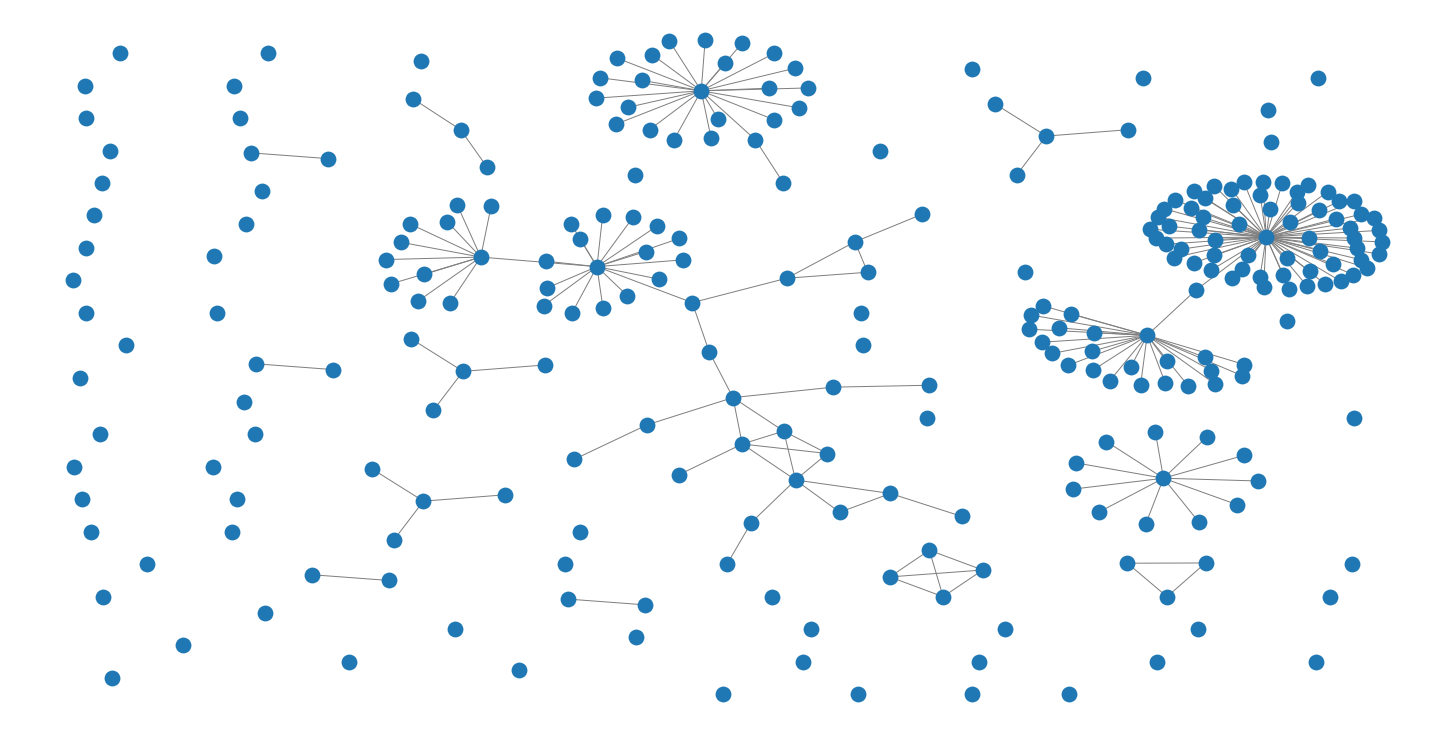

In [49]:
plt.figure(figsize=(20,10))
nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=250, \
        edge_color = 'grey',linewidths=0.01, font_size=16, \
    font_weight='bold')
plt.show()


In [50]:
# modules for data collection
import GetOldTweets3 as got3
import tweepy
# developer account keys -- create twitter_credentials.py
import twitter_credentials as tc


# create a function to authenticate our access to API
def authenticate(api_key, secret_key, access_token, secret_token):

    auth = tweepy.OAuthHandler(api_key, secret_key)
    auth.set_access_token(access_token, secret_token)
    api = tweepy.API(auth, 
                     wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)
  
    return api


api = authenticate(tc.api_key, tc.secret_key, tc.access_token, tc.secret_token)
verified = []
followers_count = []
screen_name_ = []

usernames = list(G.nodes)

for i in usernames:
    try:
        user = api.get_user(screen_name = i) 
        screen_name_.append(user.screen_name)
        verified.append(user.verified)
        followers_count.append(user.followers_count)


    except tweepy.error.TweepError as t:
        if t.api_code == 50: # The code corresponding to the user not found error
            print("username that failed=",  user.screen_name)
            # accounts_L.remove(screen_name)
        elif t.api_code == 88: # The code for the rate limit error
            time.sleep(15*60) # Sleep for 15 minutes
    else:# if no error
        continue
        
# we will store them in accounts
accounts = pd.DataFrame({'name': screen_name_,'verified': verified,'followers': followers_count})
accounts

username that failed= natalieben
username that failed= leapingotter


,name,verified,followers
0,MikeHudema,True,127000
1,sistercelluloid,False,4766
2,Electroversenet,False,13308
3,ExtinctionR,False,355360
4,NOAA,True,1083766
...,...,...,...
260,CogitoErgoSumAu,False,1297
261,WORSHIPMYROAST,False,64607
262,claudeforthomme,False,5160
263,ShankarSharvari,False,1249


In [51]:
accounts = accounts.iloc[:,:2]

df_node = pd.DataFrame({'col':usernames})
df_node = df_node.merge(accounts,how="left",left_on="col",right_on="name")
df_node

,col,name,verified
0,MikeHudema,MikeHudema,True
1,sistercelluloid,sistercelluloid,False
2,Electroversenet,Electroversenet,False
3,ExtinctionR,ExtinctionR,False
4,NOAA,NOAA,True
...,...,...,...
262,CogitoErgoSumAu,CogitoErgoSumAu,False
263,WORSHIPMYROAST,WORSHIPMYROAST,False
264,claudeforthomme,claudeforthomme,False
265,ShankarSharvari,ShankarSharvari,False


In [52]:
color_map = []
for node in df_node.verified:
    if node:
        color_map.append(twitter) 
    else: 
        color_map.append('lightgrey') 
len(color_map)

267

In [53]:
df_node_v = df_node[df_node['verified']==True]
df_node_v = list(df_node_v.col)
hubs = df_node_v

In [54]:
labels = {}    
for node in G.nodes():
    if node in hubs:
        #set the node name as the key and the label as its value 
        labels[node] = node

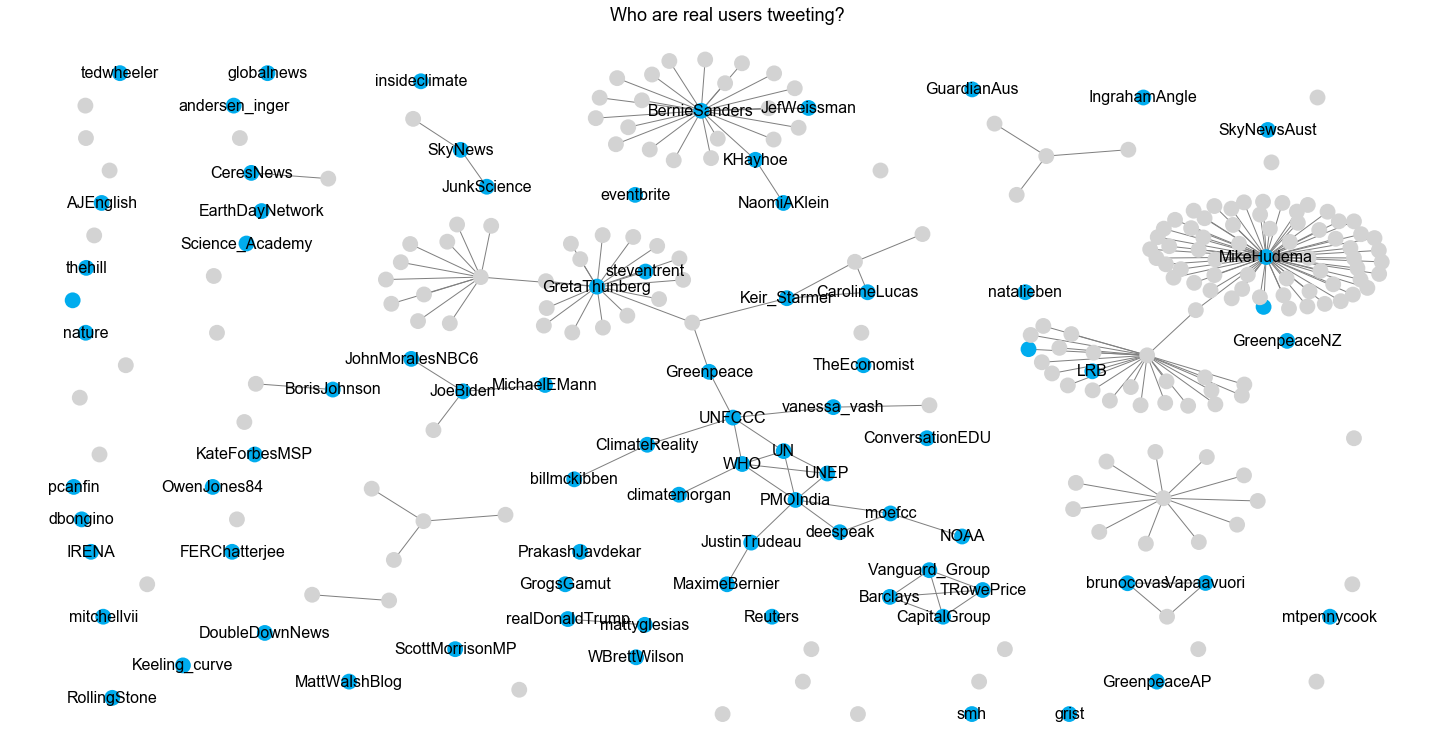

In [55]:
plt.figure(figsize=(20,10))
nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=250, \
    node_color=color_map, edge_color = 'grey',linewidths=0.01, font_size=16, \
    font_weight='bold')
nx.draw_networkx_labels(G,nx.nx_pydot.graphviz_layout(G),labels,font_size=16,font_color='black')
plt.title("Who are real users tweeting?",fontsize=18)
plt.show()

In [56]:
degrees = [val for (node, val) in G.degree()]

In [57]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [58]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [59]:
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 nodes by degree:
('MikeHudema', 63)
('tan123', 23)
('BernieSanders', 22)
('GretaThunberg', 17)
('ExtinctionR', 11)
('JWSpry', 11)
('PMOIndia', 6)
('UNFCCC', 5)
('WHO', 5)
('UN', 4)
('Barclays', 3)
('JoeBiden', 3)
('commondreams', 3)
('Keir_Starmer', 3)
('TRowePrice', 3)
('XRebellionUK', 3)
('moefcc', 3)
('GeorgeMonbiot', 3)
('impakterdotcom', 3)
('UNEP', 3)
